**Q2** Start with our imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
from scipy.integrate import solve_ivp

Now define a function that computes the derivative of M and log(rho), when given an input r, M and log(rho).

In [3]:
def M_rho_deriv_degen(r_in_rsun, M_lrho, Z_on_A=0.5):
    """Find the Mass and density derivatives for solving a degenerate
    star equation of state problem. We have log(rho) as an input to help
    with numerics, as rho can never be negative.
    
    Parameters
    ----------
    M_lrho: numpy array-like, including M in solar units, rho in g/cm^3.
    
    Returns
    -------
    derivatives: Derivatives of M in solar units, log(rho in g/cm^3), with respect 
        to r_in_rsun, as a numpy array-like variable.
    """
    M_in_Msun, lrho = M_lrho
    
    #Lets create a variable rho in real units
    rho = np.exp(lrho)*u.g/u.cm**3
    
    #Mass continuity. Convert to dimensionless units
    dM_in_Msundr = float(4*np.pi*r_in_rsun**2*rho * c.R_sun**3/c.M_sun)
    
    #Fermi momentum
    p_F = ( c.h/2*(3*rho*Z_on_A/np.pi/u.u)**(1/3) ).cgs
    
    #dPdrho - should have units of (velocity)^2
    dPdrho = ( p_F**2*c.c/3/u.u/np.sqrt(p_F**2 + c.m_e**2*c.c**2) * Z_on_A ).cgs
    
    #drho/dr
    if r_in_rsun==0:
        dlrhodr = 0
    else:
        dlrhodr = -(c.G*M_in_Msun*c.M_sun/(r_in_rsun*c.R_sun)**2 / dPdrho)\
            .to(1/c.R_sun).value
    
    return np.array([dM_in_Msundr, dlrhodr])
    
#The following function may be slightly confusing for people who aren't python or 
#object oriented programming experts, as variables (properties) are added to a function. 
#We can actually always add additional properties to functions, as all variables and
#functions in python are objects.
def near_surface(r_in_rsun, M_lrho):
    """Determine a surface condition by the surface becoming too cool. In practice, 
    our adiabatic approximation is likely to break before this!"""
    return M_lrho[1] - np.log(1e-3)
near_surface.terminal = True
near_surface.direction = -1

Use this function, combined with `scipy`'s `solve_ivp` function to solve the differential equation when starting with a central density $\rho_c$. 

In [4]:
def wd_structure(rho_c):
    """Assuming a fully degenerate equation of state, compute the interior structure
    of a white dwarf, including its outer radius and mass.
    
    Parameters
    ----------
    rho_c: Central density, including units from astropy.units
    """
    #Start the problem at the white dwarf center.
    y0 = [0, np.log(rho_c.to(u.g/u.cm**3).value)]
    
    #Don't go past 1 R_sun!
    rspan = [0,1] 
    
    #Solve the initial value problem!
    result = solve_ivp(M_rho_deriv_degen, [0,100], y0, events=[near_surface], method='RK23') 
    
    #Extract the results
    r_in_rsun = result.t
    M_in_Msun = result.y[0]
    rho = np.exp(result.y[1])*u.g/u.cm**3
    return r_in_rsun, M_in_Msun, rho

**(a)** Modify some of the code below to help with this question. First, you will have to re-arrange (2) with the Fermi momentum being $m_e c$. 

Critical density is: 1.95e+06 g / cm3


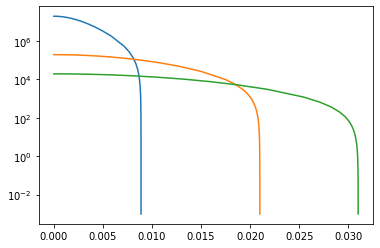

In [11]:
Z_on_A=0.5
critical_density = 8*c.m_e**3*c.c**3*np.pi*u.u/3/c.h**3/Z_on_A
print('Critical density is: {:.2e}'.format(critical_density.cgs))
#Try 10 times lower than the critical density
r_in_rsun, M_in_Msun, rho = wd_structure(critical_density*10)
plt.semilogy(r_in_rsun, rho)
#Try 10 times lower than the critical density
r_in_rsun, M_in_Msun, rho = wd_structure(critical_density/10)
plt.semilogy(r_in_rsun, rho)
#Now 100 times lower.
r_in_rsun, M_in_Msun, rho = wd_structure(critical_density/100)
plt.semilogy(r_in_rsun, rho)

**(b)** Pen and paper plus quick calculation. [Hint: Equate electron pressure with gas pressure, with a mean molecular weight of 0.5]

In [13]:
M_in_Msun

array([0.00000000e+00, 1.38163426e-08, 1.15300067e-05, 7.87444373e-05,
       2.58898968e-04, 6.37561191e-04, 1.37290648e-03, 2.80199203e-03,
       5.81504258e-03, 1.26340799e-02, 2.21975039e-02, 3.32534688e-02,
       4.45350858e-02, 5.54659399e-02, 6.41795418e-02, 6.63594383e-02,
       6.73553854e-02, 6.77514440e-02, 6.79123791e-02, 6.79782992e-02,
       6.80056992e-02, 6.80172872e-02, 6.80222871e-02, 6.80244938e-02,
       6.80254925e-02, 6.80259573e-02, 6.80261801e-02, 6.80262903e-02,
       6.80263464e-02, 6.80263753e-02, 6.80263903e-02, 6.80264025e-02,
       6.80264139e-02, 6.80264224e-02, 6.80264268e-02, 6.80264291e-02,
       6.80264303e-02, 6.80264308e-02, 6.80264311e-02, 6.80264312e-02,
       6.80264312e-02, 6.80264312e-02, 6.80264313e-02, 6.80264313e-02,
       6.80264313e-02, 6.80264313e-02])

**(c)** Here are some code snippets to help...

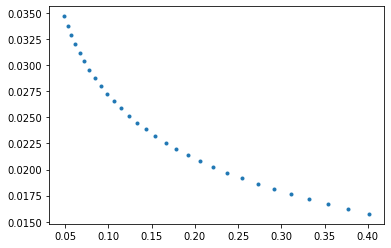

In [15]:
rho_cs = np.linspace(np.log10(1e4), np.log10(1e6), 30)
Ms = []
Rs = []
for rho_c in rho_cs:
    r_in_rsun, M_in_Msun, rho = wd_structure(10**rho_c*u.g/u.cm**3)
    #for an array x, the value x[-1] is the last value in the array.
    Ms.append(M_in_Msun[-1])
    Rs.append(r_in_rsun[-1])

#Here is a plot with dots. Use xlabel and ylabel to label.
plt.plot(Ms, Rs, '.')

In [16]:
Ms

[0.04905092843063587,
 0.05303670889811976,
 0.05733841063586255,
 0.061975943046664136,
 0.06698886835824247,
 0.07237393432796277,
 0.07818354485330312,
 0.08441732013762107,
 0.09115145758142695,
 0.09839774921011593,
 0.10618716711458738,
 0.1145661910516416,
 0.12351736081754015,
 0.13311875146458402,
 0.14340483705573168,
 0.15441190881016273,
 0.16618273837541314,
 0.17876560667086466,
 0.1921805103805993,
 0.20647016997598763,
 0.22158468234545659,
 0.2376811770801784,
 0.25460912023380516,
 0.27256039991295594,
 0.2914886468312394,
 0.3113985832440805,
 0.3323163491501697,
 0.35430168808908274,
 0.3773122629192468,
 0.401051208474282]